# SVC: C-Support Vector Classification

_A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side._ (from [here](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72))

In [13]:
%matplotlib inline

# Reading files
import h5py
import toml

# Scientific computing
import numpy as np
import pandas as pd
from scipy import interp

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#sns.set_context('paper')

# Machine Learning
## Model
from sklearn.svm import SVC
## Splitter Classes
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
# Splitter Functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# Hyper-parameter optimizers
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Model validation
from sklearn.model_selection import learning_curve
# Training metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Other
import os
import time
import requests

## Preparation

Load data and target from `classification/ris/OUT-classified-merged.h5` and load into numpy arrays.

**Label `0` = NO GLITCH**

**Label `1` = GLITCH**

In [2]:
first_cycle = True
with pd.HDFStore('../../classification/ris/OUT-classified-merged.h5', mode='r') as in_data:
    for group in ['GLITCH', 'NO_GLITCH']:
        if first_cycle == True:
            data = np.array(in_data[group].to_numpy())
            if group == 'GLITCH':
                target = np.ones(len(data))
            elif group == 'NO_GLITCH':
                target = np.zeros(len(data))
            else:
                print("ERROR.")
            first_cycle = False
        else:
            data = np.concatenate((data, in_data[group].to_numpy()))
            if group == 'GLITCH':
                target = np.concatenate((target, np.ones(len(in_data[group].to_numpy()))))
            elif group == 'NO_GLITCH':
                target = np.concatenate((target, np.zeros(len(in_data[group].to_numpy()))))
            else:
                print("ERROR.")

## Best Training

Initialize best hyper-parameters founded.

In [24]:
best_kernel = 'rbf'
best_gamma = 0.0145
best_C = 8.7

### Cross validation

Use k-fold to make a cross validation of the model.

In [25]:
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C)

# k-fold

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
scores_rkf = np.array([])
# Make k-fold CV
for train_index, test_index in rkf.split(data, target):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    scores_rkf = np.append(scores_rkf, clf.score(X_test, y_test))
# Print final score
print("Average score (k-fold):", scores_rkf.mean())


# Stratified k-fold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=None)
scores_rskf = np.array([])
# Make k-fold CV
for train_index, test_index in rskf.split(data, target):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    scores_rskf = np.append(scores_rskf, clf.score(X_test, y_test))
# Print final score
print("Average score (Stratified k-fold):", scores_rskf.mean())

Average score (k-fold): 0.9795965417867436
Average score (Stratified k-fold): 0.9789628069558697


### Confusion matrix

Function `print_confusion_matrix`

In [5]:
def print_confusion_matrix(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    columnwidth = max([len(str(x)) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    
    # Begin CHANGES
    fst_empty_cell = (columnwidth-3)//2 * " " + "t\p" + (columnwidth-3)//2 * " "
    
    if len(fst_empty_cell) < len(empty_cell):
        fst_empty_cell = " " * (len(empty_cell) - len(fst_empty_cell)) + fst_empty_cell
    # Print header
    print("    " + fst_empty_cell, end=" ")
    # End CHANGES
    
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
        
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

Function `plot_confusion_matrix`

In [6]:
def plot_confusion_matrix(cm, labels, normalize=True):
    
    # Create DataFrame
    df_cm = pd.DataFrame(cm, columns=labels, index=labels)
    df_cm.index.name = 'True label'
    df_cm.columns.name = 'Predicted label'
    
    # Normalize
    if normalize:
        df_cm = df_cm.div(df_cm.sum(axis=1), axis=0).round(decimals=2)
    
    # Plot
    fig, ax = plt.subplots()
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True)
    axlim = ax.get_ylim()
    ax.set_ylim(axlim[0] + 0.5, axlim[1] - 0.5)
    if normalize:
        ax.set_title('Confusion matrix (with normalization)')
    else:
        ax.set_title('Confusion matrix (without normalization)')
    
    return fig, ax

Print confusion matrix.

Text confusion matrix (without normalization)

       t\p    no glitch    glitch 
    no glitch     284.0       6.0 
       glitch       2.0     229.0 


Graphic confusion matrix (normalized)



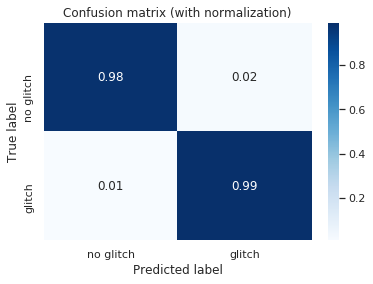

In [8]:
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0, )
# Train and predict
y_pred = clf.fit(X_train, y_train).predict(X_test)

# Compute confusion matrix
labels = [0., 1.]
labels_text = ['no glitch', 'glitch']
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Print confusion matrix
print('Text confusion matrix (without normalization)\n')
print_confusion_matrix(cm, labels_text)
print('\n\nGraphic confusion matrix (normalized)\n')
fig, ax = plot_confusion_matrix(cm, labels_text, normalize=True)
fig.savefig('confusion_matrix.png', dpi=800)

### Learning curve

Function `plot_learning_curve`

In [9]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predbest_test_scorehods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    #plt.figure(figsize = (9,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    #plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')

    plt.legend(loc='best')
    
    return plt

Plot the learning curve.

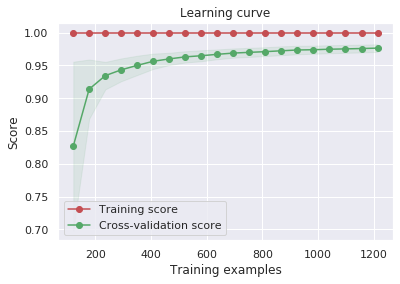

In [10]:
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C)
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

fig = plot_learning_curve(clf, 'Learning curve', data, target, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20))
fig.savefig('learning_curve.png', dpi=800)

### ROC curve

Function `plot_roc_curve`

In [35]:
def plot_roc_curve(estimator, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(data, target):
        probas_ = clf.fit(data[train], target[train]).predict_proba(data[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(target[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    
    return plt, mean_auc

Plot the ROC curve.

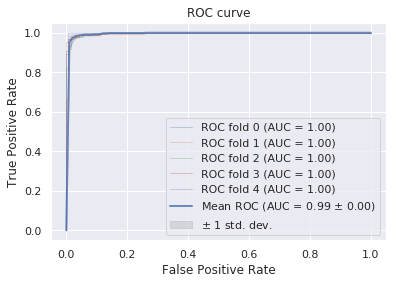

In [43]:
clf = SVC(kernel=best_kernel, gamma=best_gamma, C=best_C, probability=True)
cv = StratifiedKFold(n_splits=5)

fig, mean_auc = plot_roc_curve(clf, cv)
fig.savefig('roc_curve.png', dpi=800)

## Tuning the hyper-parameters

### Kernel: `rbf`

#### Grid Search

### Kernel: `sigmoid`

Best parameters set found on development set: `{'C': 0.38000000000000006, 'coef0': -1.55, 'gamma': 0.0029500000000000012}`

Score: $0.7365370516420923$

#### Randomized Search

#### Grid Search